## Start with the basic

Here we do the following operations to verify the workflow:
+ create test points in 3D space **XYZ** where we assume the points to be in the camera frame plane
+ apply camera projection matrix to go from 3D to 2D
+ normalize the point to **xyz**
+ apply rotation matrix **R**
+ convert the points **xyz'** that are supposed to be a spherical surface to an equirectangular image of coordinates **theta phi**
+ convert the **thet phi** point to **uv** texture as it is processed in the regular workflow

Then do all the operation in the other direction from **uv** texture coordinates to camera plane.
Apply 
Based in the previous transformation compute the inverse transformation.


from Camera point to 

In [18]:
import sys, os
import cv2
import math
import matplotlib.pyplot as plt
import matplotlib as mpl
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.patches as patches
%matplotlib inline 
import numpy as np
import projectionAnalysisTool

fov = 82 
frameFull = cv2.imread('test_image.jpg')
frame = cv2.resize(frameFull, (np.shape(frameFull)[1] / 6, np.shape(frameFull)[0] / 6), interpolation = cv2.INTER_CUBIC)

# fake equirectangular image of ratio 2:1
pano_color = np.zeros((1024, 2048, 3))
reload(projectionAnalysisTool)

<module 'projectionAnalysisTool' from 'projectionAnalysisTool.pyc'>

## Create the camera matrix
For that we need the image dimension. This can be also read from the config file.

In [6]:
# for the camera matrix
im_width    = np.shape(frame)[1]
im_height   = np.shape(frame)[0]

# for the uv texture coordinates later on
pano_width  = np.shape(pano_color)[1]
pano_height = np.shape(pano_color)[0]

print im_width, im_height, pano_width, pano_height
K = projectionAnalysisTool.fun_create_camera_matrix(fov, im_width, im_height)
K_inv = np.linalg.pinv(K)

544 408 2048 1024


## Create some test points
The points simulated pixel position in the camera frame.

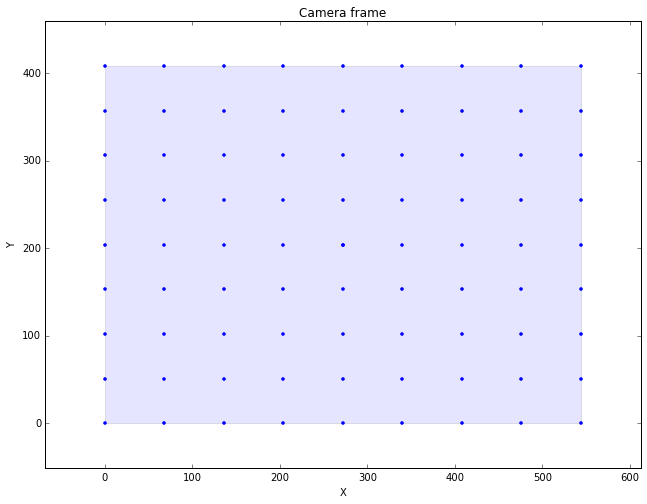

In [7]:
data_XYZ = projectionAnalysisTool.fun_create_test_points(im_width, im_height, sample_step= 9)

# display the point in the camera frame
projectionAnalysisTool.fun_display_points_in_camera_frame(data_XYZ, frame)

# Forward Mapping
## 1 Inverse projection camera toward sphere
**p'** = **K^-1**p where **K^-1** is the inverse camera projection matrix.

Once the inverse camera matrix is applied, the data need to be normalized to apply further rotations.


In [8]:
data_xyz_NotNormalized = projectionAnalysisTool.fun_apply_mat_to_points(K_inv, data_XYZ)
data_xyz_Normalized   = projectionAnalysisTool.fun_normalize_XYZ(data_xyz_NotNormalized)

# check that the data are correctly normalized
#print  np.sqrt(np.sum(data_xyz**2,axis=0))

## 2 Apply rotation
We can choose between different test rotation matrix
+ identity matrix such that nothing should happen
+ a rotation matrix with a given angle around the z axis
+ a rotation matrix read from the config file

In [9]:
# identity
R = np.eye(3)

# with a given rotation angle
R = projectionAnalysisTool.fun_create_Rotation_Matrix_Zaxis(np.pi / 12) # a rotation should happen

# from config file
#R = projectionAnalysisTool.fun_get_Rotation_Matrix_from_Report(index_image+1, dir_to_inspect)

# apply rotation
data_xyzR = projectionAnalysisTool.fun_apply_mat_to_points(R, data_xyz_Normalized)

##  3 Convert the spherical data to angle texture coordinates
We go from normalized **xyz** 3D data to **theta phi** 2D data.

And we follow by displaying the 2D data.

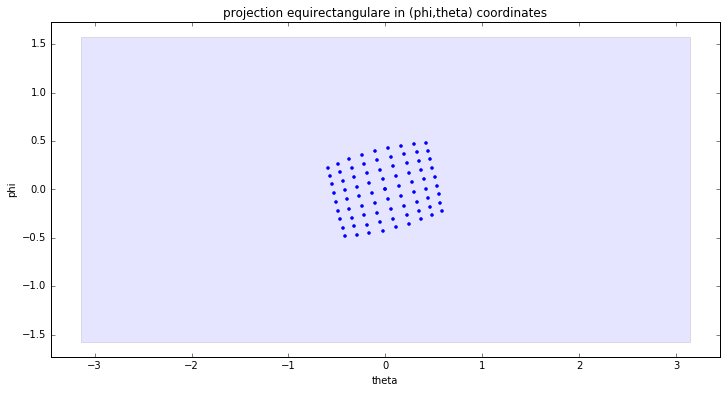

In [10]:
data_theta_phi = projectionAnalysisTool.fun_xyz2theta_phi(data_xyzR)

# display the point in the (theta, phi) equirectangular plan
projectionAnalysisTool.fun_display_points_in_angle_texture_map(data_theta_phi)

## 4 Convert to texture coordinate
Here nothing should really change with the previous transformation, just a scaling factor is applied to move into the the same **uv** texture coordinates.

We also display the point on the top of recorded panorama image.

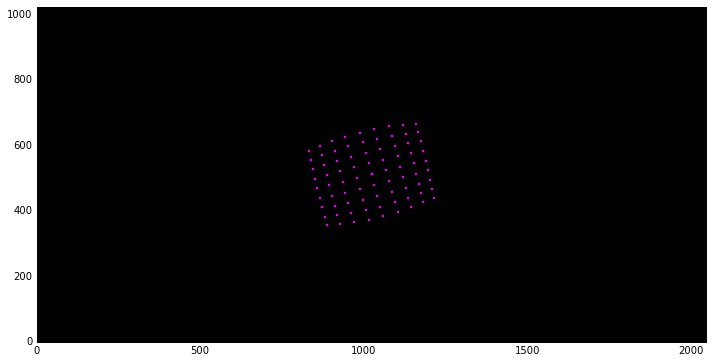

In [11]:
data_uv = projectionAnalysisTool.fun_theta_phi2uv(data_theta_phi, pano_width, pano_height)

# look at the data
projectionAnalysisTool.fun_display_point_in_uv_texture_map(data_uv, pano_color)

# Backward Mapping
The same as before but backward.

We do the reverse path (uv) -> (theta, phi) -> (xyz) -> (XY)

## 1 Convert texture coordinate to theta phi coordinates

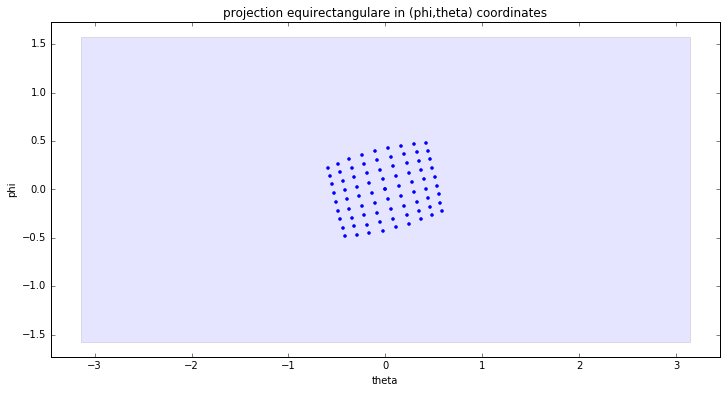

In [12]:
data_theta_phi_ = projectionAnalysisTool.fun_uv2theta_phi(data_uv, pano_width, pano_height)

# display the data that should looks like above
projectionAnalysisTool.fun_display_points_in_angle_texture_map(data_theta_phi_)

## 2 Convert Theta Phi to xyz
We now remap the data the spherical coordinates, we do 2D to 3D

In [13]:
data_xyz_ = projectionAnalysisTool.fun_theta_phi2xyz(data_theta_phi_)

## 3 Apply inverse (or not) rotation
For our test here we can apply the inverse of the **R** rotation matrix previously defined.

In [14]:
R_inv = projectionAnalysisTool.fun_create_Rotation_Matrix_Zaxis(- np.pi / 11)#np.linalg.inv(R)
data_xyz_r = projectionAnalysisTool.fun_apply_mat_to_points(R_inv, data_xyz_)
#print  np.sqrt(np.sum(data_xyz_**2,axis=0))

## 4 Finally the camera matrix
Now we want to project the 3D points into the camera frame.

And we de-normalize the data before displaying them.

In [15]:
data_XYZ_ = projectionAnalysisTool.fun_apply_mat_to_points(K, data_xyz_r)

# denormalized the data
data_XYZ_dn = projectionAnalysisTool.fun_denormalized(data_XYZ_)

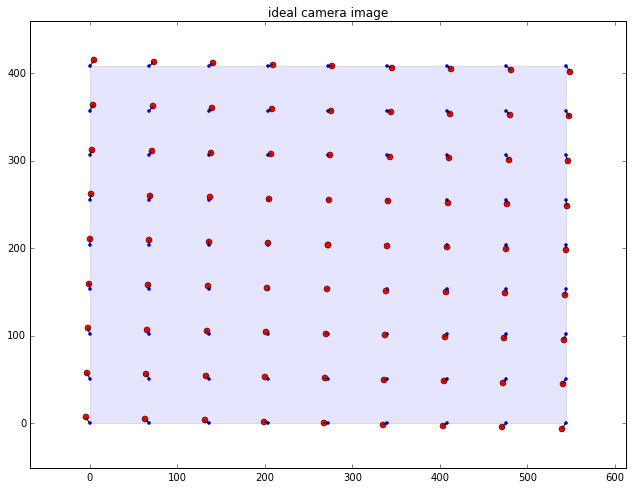

In [16]:
# we display the shit
projectionAnalysisTool.fun_display_two_sets_of_points_in_camera_frame(data_XYZ, data_XYZ_dn, frame)